In [1]:
import os                   # to interact with the operating system
import glob

import numpy as np
import pandas as pd
import xarray as xr

import pop_tools
import gsw                  # compute potential density

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
import cmocean.cm as cmo
import matplotlib.ticker as ticker

In [2]:
# setting up of regional mask
grid_name = 'POP_gx1v7'
region_defs = {
    'North Atlantic and Nordic Seas': [{'match': {'REGION_MASK': [6, 7, 9]}, 
                             'bounds': {'TLAT': [20., 78.]}}],
    'LabradorSea': [{'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [45.0, 66.0]}}]
} 
mask3d = pop_tools.region_mask_3d(grid_name, region_defs=region_defs, mask_name='North Atlantic and Nordic Seas')
mask3d = mask3d.sum('region')

def find_corresponding_number(vvel_filename):
    with open(os.path.expanduser('~/phase1_CONDA/timeseries/order.txt'), 'r') as file:
        vvel_list = file.readlines()
    vvel_dict = {filename.split()[1]: int(filename.split()[0]) for filename in vvel_list}
    vvel_number_to_find = None
    for filename in vvel_list:
        if filename.split()[1] == vvel_filename:
            vvel_number_to_find = vvel_dict[filename.split()[1]]
            break
    return vvel_number_to_find

def find_corresponding_file_name(vvel_number_to_find):
    with open(os.path.expanduser('~/phase1_CONDA/timeseries/order.txt'), 'r') as file:
        vvel_list = file.readlines()
    vvel_dict = {filename.split()[1]: int(filename.split()[0]) for filename in vvel_list}
    vvel_filename = None
    for filename in vvel_list:
        if vvel_dict[filename.split()[1]] == vvel_number_to_find:
            vvel_filename = filename.split()[1]  
            break
    return vvel_filename

# Load data from 'events_dens_spg.csv' into a NumPy array.
data = np.genfromtxt('events_dens_spg.csv', delimiter=',', names=True, dtype=None)

# Accessing columns by name
member_numbers = data['Index']
events = data['Values']
member_names = []

for i in range(len(member_numbers)):
    member_names.append(find_corresponding_file_name(member_numbers[i])[5:])

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# Plot Composites

In [3]:
ccrs = cartopy.crs

sigma_file = os.path.expanduser('~/phase1_CONDA/')+'/results/composites/sigma_anomaly.nc'
difference_sigma = xr.open_dataset(sigma_file)
vmin = -abs(difference_sigma.SIGMA_2).max()
vmax = abs(difference_sigma.SIGMA_2).max()

### DENS

Text(0.5, 1.0, '0-1000 meters Density Anomaly')

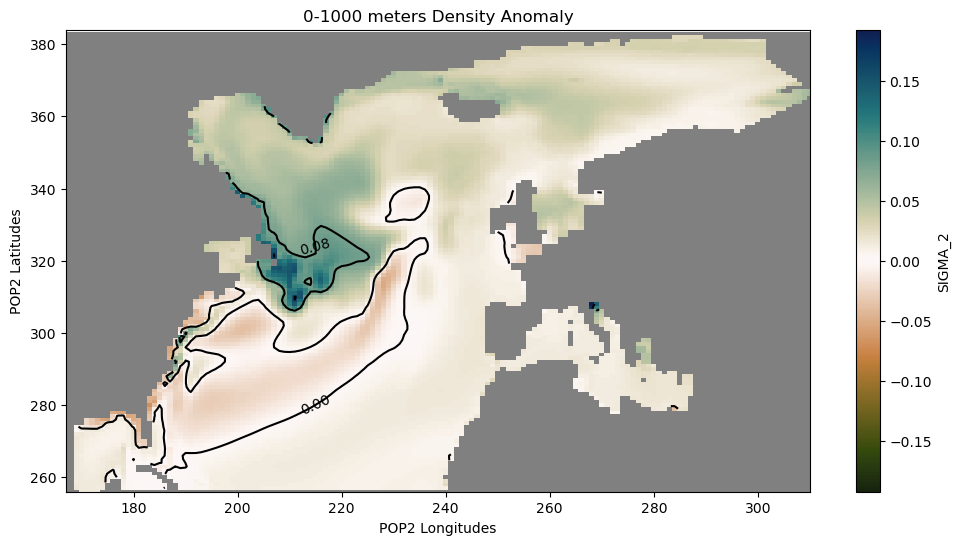

In [4]:
field = difference_sigma.SIGMA_2.sel(z_t=slice(5.0000000e+02, 8.7882523e+04)).mean('z_t')

cmap = cmo.tarn
cmap.set_bad('gray')

plt.figure(figsize=(12, 6))
horiz_sigma_plot = field.plot(cmap=cmo.tarn)#, vmin=vmin_sigma, vmax=vmax_sigma)
contour_sigma = field.plot.contour(colors='k') 
plt.clabel(contour_sigma, inline=False, fontsize=10)

plt.xlim([167, 310])
plt.ylim([256, 384])
plt.ylabel('POP2 Latitudes')
plt.xlabel('POP2 Longitudes')
plt.title('0-1000 meters Density Anomaly')
#plt.show()

#### latitudinal section

In [5]:
cmap = cmo.tarn
cmap.set_bad('gray')

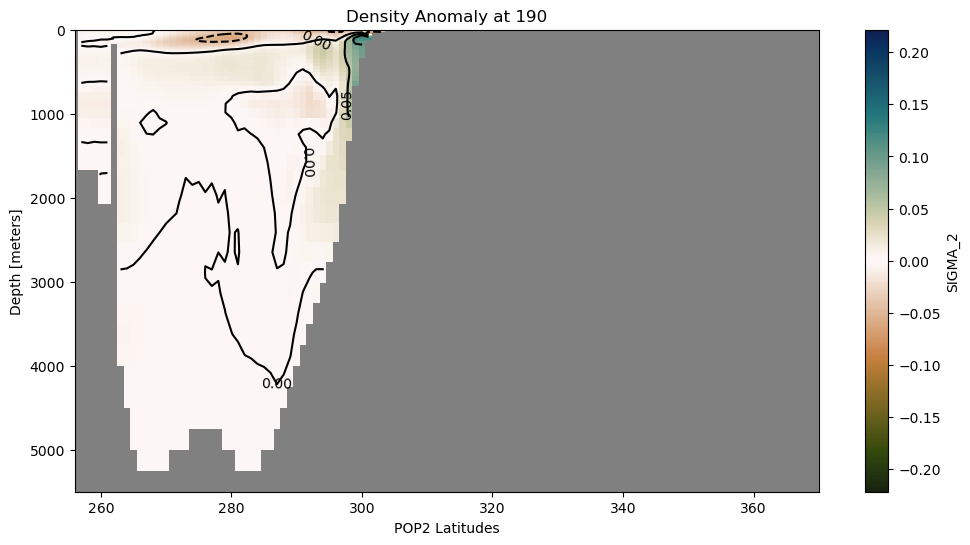

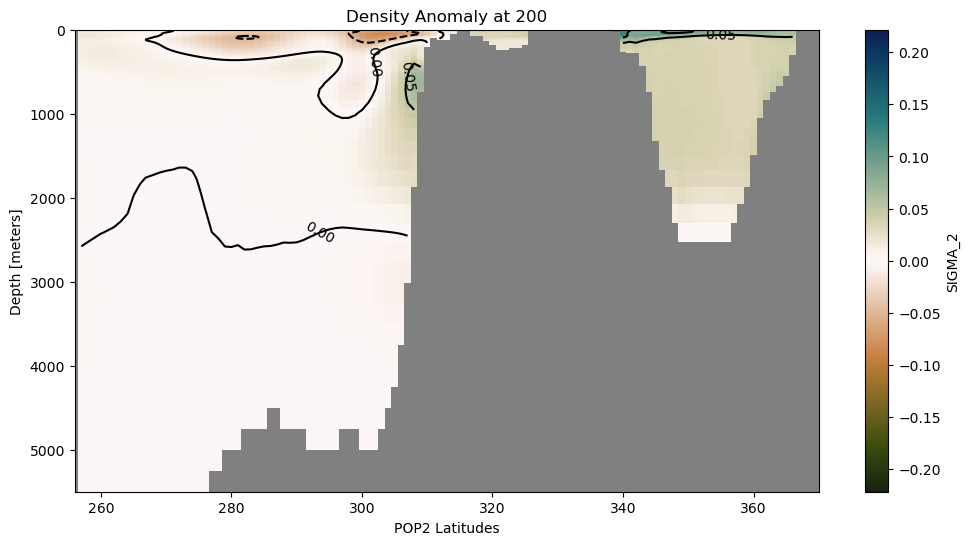

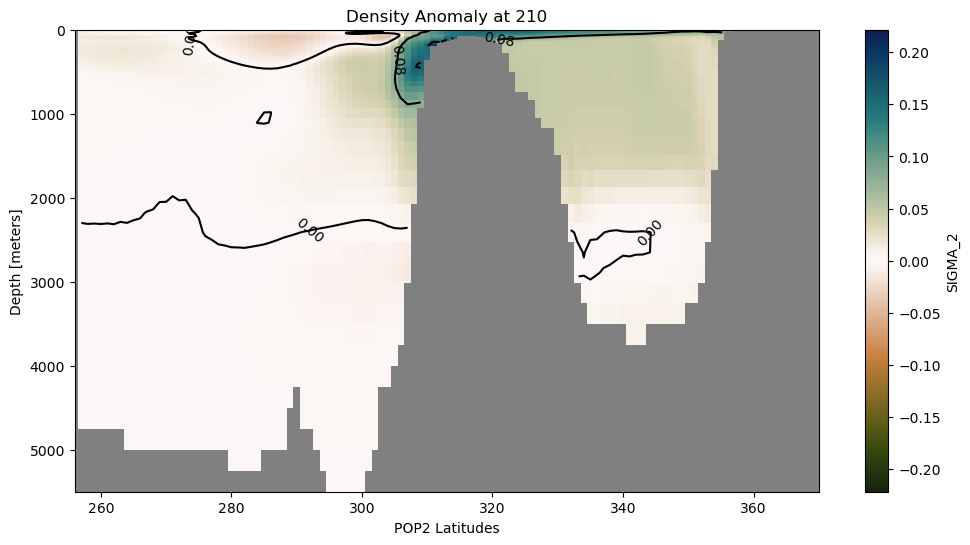

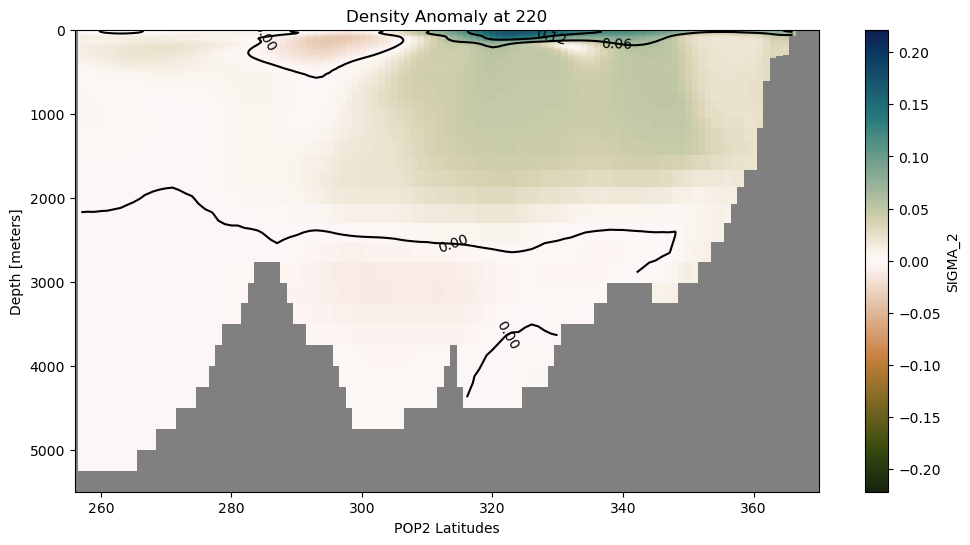

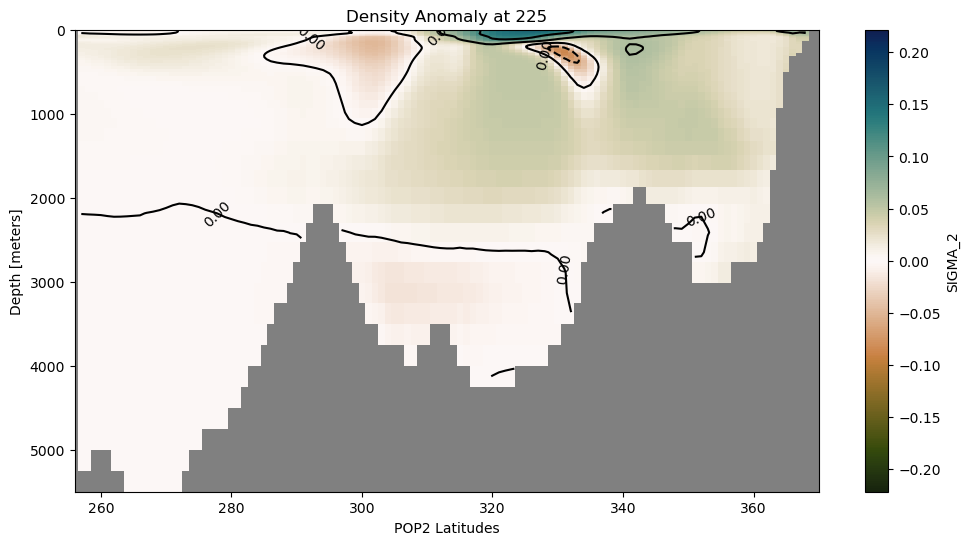

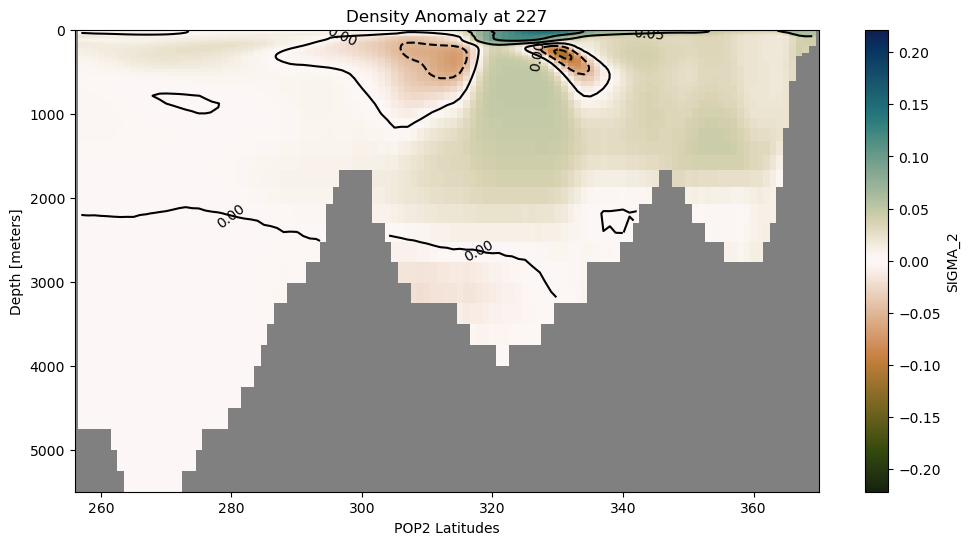

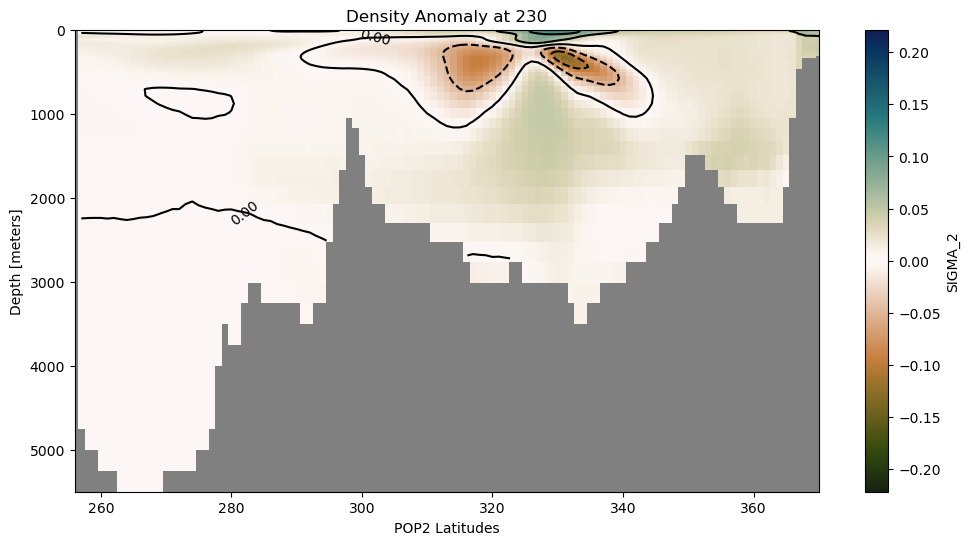

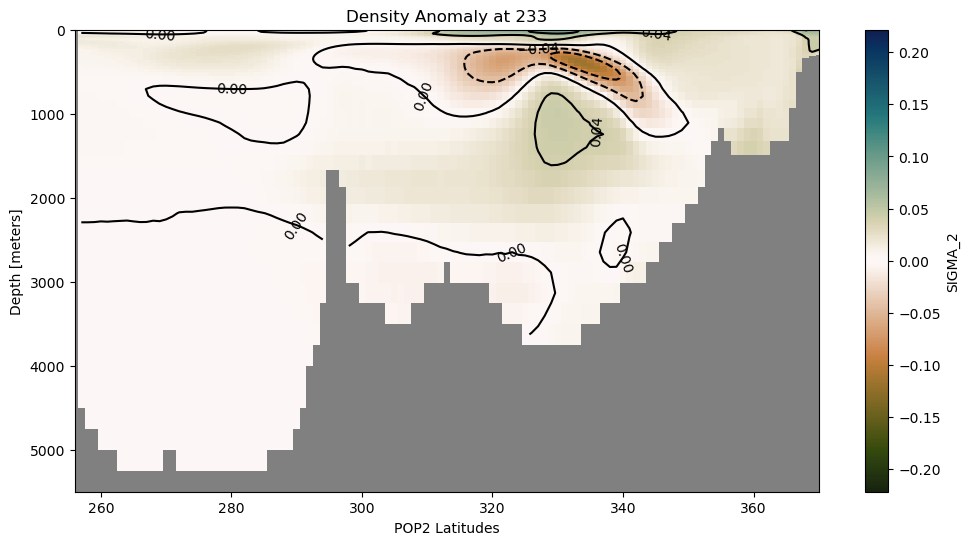

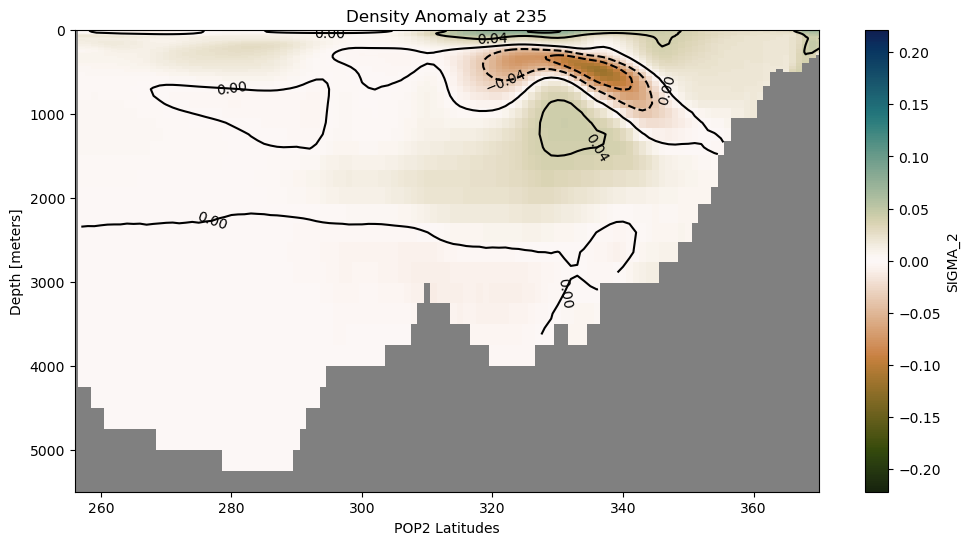

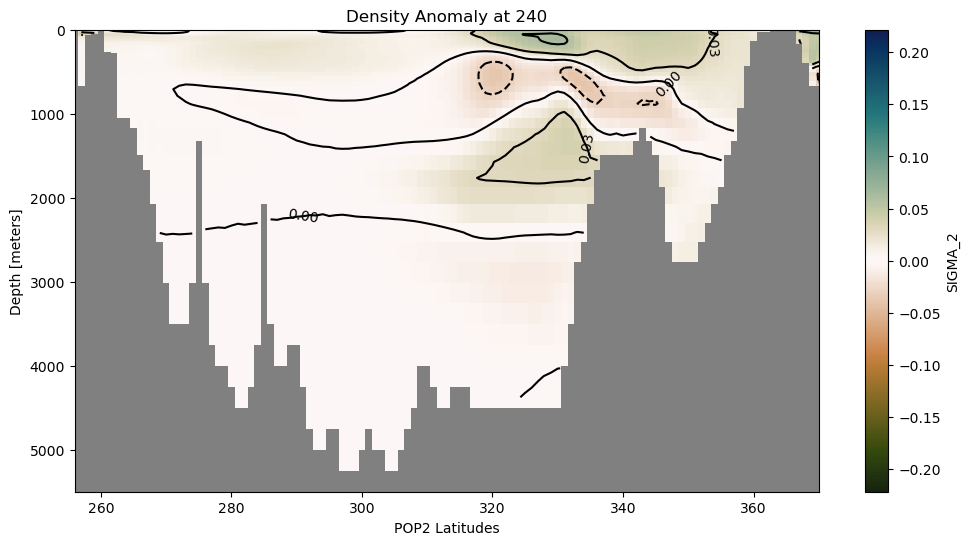

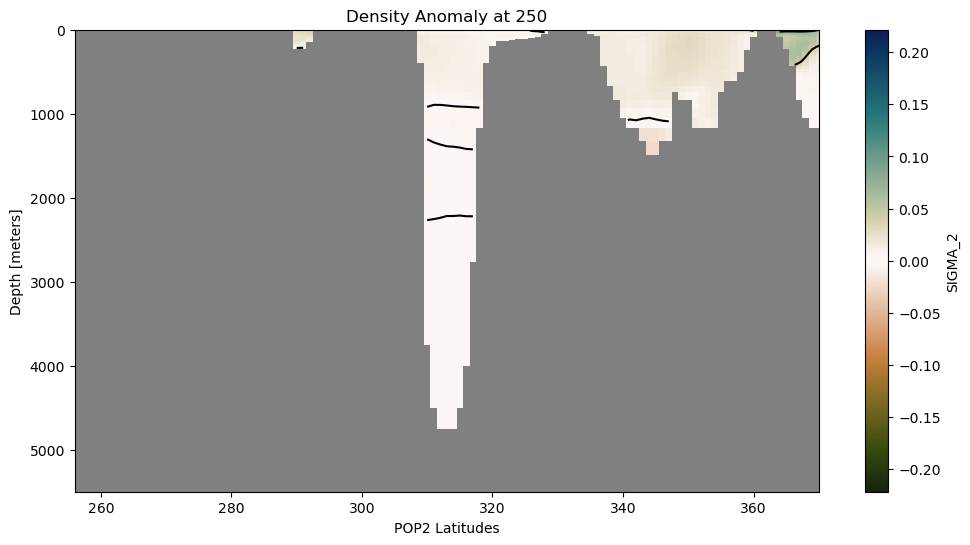

In [7]:
nlons = [190, 200, 210, 220, 225, 227, 230, 233, 235, 240, 250]

for nlon in nlons:
    field = difference_sigma.SIGMA_2.isel(nlon=nlon)


    plt.figure(figsize=(12, 6))
    lati_sigma_plot = field.plot(cmap=cmap,yincrease=False, vmin=vmin, vmax=vmax)
    contour = field.plot.contour(colors='k') 
    plt.clabel(contour, inline=False, fontsize=10)

    plt.xlim([256, 370])
    plt.ylabel('Depth [meters]')
    plt.xlabel('POP2 Latitudes')
    plt.title('Density Anomaly at '+str(nlon))

    plt.gca().invert_yaxis()
    new_y_labels = ['0','1000', '2000', '3000', '4000', '5000']
    plt.yticks([0,100000, 200000, 300000, 400000, 500000], labels=new_y_labels)

    #plt.show()
    plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'sigma_anomaly-'+str(nlon)+'.png', bbox_inches='tight', dpi=300)

# Plot average years

In [7]:
# composite locations
comp_files = sorted(glob.glob('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/*.nc'))

# Remove the file at the specified index
comp_files.pop(10)

'/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/composite_1301.001.nc'

In [8]:
for i in range(len(comp_files)):
    try:
        ds = xr.open_dataset(comp_files[i])
        print(f"{comp_files[i]} exists")
        # Do further processing with the dataset 'ds' if needed
    except ValueError as e:
        print(f"Error opening dataset from file {comp_files[i]}: {e}")
        # Handle the exception, for example, continue with the next file
        continue
        
    average_data = ds[variable_name]
    

/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/composite_1231.001.nc exists
/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/composite_1231.003.nc exists
/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/composite_1231.004.nc exists
/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/composite_1231.020.nc exists
/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/composite_1251.010.nc exists
/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/composite_1281.010.nc exists
/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/composite_1281.012.nc exists
/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/composite_1281.015.nc exists
/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/composite_1281.017.nc exists
/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/composite_1281.020.nc exists
/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/composite_1301.015.nc exists
/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/composite_1301.019.nc

In [12]:


# Choose the variable to extract
variable = 'TEMP'
        
ds = xr.open_mfdataset(comp_files)
average_data = ds[variable_name].isel(time=slice(0,59)).mean(dim='file')

ValueError: Resulting object does not have monotonic global indexes along dimension time

In [ ]:

# Choose the variable to extract
variable = 'TEMP'
        
ds = xr.open_mfdataset(comp_files)
average_data = ds[variable_name]
product = xr.concat(average_data, dim='file').mean(dim='file')